# Sleep Detection EDA

In [36]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Loading data
- Data is quite large so we use <b>Polars</b> instead of </b>Pandas</b> for major transformations.

In [17]:
train_data_file = 'child-mind-institute-detect-sleep-states/sleep_detection_labeled_120_series.csv'

In [18]:
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
})

In [19]:
df.head()

series_id,step,dt_minute,anglez_mean,anglez_std,anglez_max,anglez_min,enmo_mean,enmo_std,enmo_max,enmo_min,anglez_1st_diffs_sum,enmo_1st_diffs_sum,target
str,i64,datetime[μs],i64,f64,i64,i64,i64,f64,i64,i64,i64,i64,i64
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,0.289,-86,-87,15,0.778,17,14,1,7,0
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,0.289,-86,-87,15,0.0,15,15,2,0,0
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,1.24,-83,-88,19,13.748,63,15,13,106,0
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,0.0,-86,-86,14,0.289,15,14,0,1,0
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,0.0,-86,-86,14,0.515,15,14,0,6,0


#### Do we have any NULLs or NaNs?
- No, data is complete.

##### Any NaN's?

In [11]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_nan().sum()).transpose(
    include_header=True, header_name="feature",column_names=["nan's"]).filter(pl.col("nan's")>0)

feature,nan's
str,u32


##### Any NULL's?

In [12]:
df.drop(["series_id","dt_minute","step_min","night_id","night_start_date"]).select(pl.all().is_null().sum()).transpose(
    include_header=True, header_name="feature",column_names=["null's"]).filter(pl.col("null's")>0)

feature,null's
str,u32


### Basic statistics of features
- There are only numeric features.

In [24]:
features = [
    "anglez_mean", "anglez_std", "anglez_max", "anglez_min",
    "enmo_mean", "enmo_std", "enmo_max", "enmo_min", "anglez_1st_diffs_sum", "enmo_1st_diffs_sum"
]

In [26]:
labels = "labels"

In [27]:
df.select(features + [labels]).describe()

describe,anglez_mean,anglez_std,anglez_max,anglez_min,enmo_mean,enmo_std,enmo_max,enmo_min,anglez_1st_diffs_sum,enmo_1st_diffs_sum,target
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",516990.0,516990.0,516990.0,516990.0,516990.0,516990.0,516990.0,516990.0,516990.0,516990.0,516990.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-10.118145,9.098346,3.873323,-24.129122,42.921089,29.867286,110.618588,14.210029,63.513851,260.057841,0.422691
"""std""",35.40238,10.506633,39.116084,37.705695,78.120996,71.660508,237.558259,26.18374,74.823758,621.28235,0.61459
"""min""",-90.0,0.0,-90.0,-90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",-33.0,0.0,-21.0,-52.0,3.0,0.389,8.0,0.0,0.0,2.0,0.0
"""50%""",-11.0,4.889,5.0,-29.0,21.0,8.857,41.0,5.0,33.0,69.0,0.0
"""75%""",9.0,15.629,31.0,-3.0,48.0,29.837,113.0,20.0,109.0,265.0,1.0
"""max""",90.0,89.224,90.0,90.0,2620.0,2121.019,6102.0,1002.0,651.0,20217.0,2.0


#### Do we have 120 series_id's?
- Yes, we do.

In [28]:
df["series_id"].unique().shape

(120,)

#### When did the observations happen?
- Between 2017-08-11 and 2019-05-31.

In [30]:
df.group_by("series_id").agg(
    pl.col("dt_minute").min().alias("start"),
    pl.col("dt_minute").max().alias("end")
).sort(by="start")

series_id,start,end
str,datetime[μs],datetime[μs]
"""e34b496b84ce""",2017-08-11 13:15:00,2017-08-14 13:14:00
"""f6d2cc003183""",2017-08-14 12:30:00,2017-08-17 12:29:00
"""def21f50dd3c""",2017-08-15 13:45:00,2017-08-18 13:44:00
"""0ce74d6d2106""",2017-08-21 16:30:00,2017-08-24 16:29:00
"""2fbbee1a38e3""",2017-08-31 12:30:00,2017-09-03 12:29:00
"""c7d693f24684""",2017-08-31 13:30:00,2017-09-03 13:29:00
"""51b23d177971""",2017-09-06 12:15:00,2017-09-09 12:14:00
"""5f94bb3e1bed""",2017-09-08 16:15:00,2017-09-11 16:14:00
"""e6ddbaaf0639""",2017-09-27 13:15:00,2017-09-30 13:14:00


### labels variable
- Our dataset is imbalanced.
- We need to check if the labels==2 will be there in all train, validation and test sets.
- We can check is adding weights in the model definition help improve the results.

In [44]:
df_labels = df.group_by("labels").agg(
    pl.col("dt_minute").count().alias("count")
)
df_labels.with_columns(frac = (pl.col("count") / df_labels["count"].sum()).round(2))

target,count,frac
i64,u32,f64
0,333023,0.64
1,149407,0.29
2,34560,0.07


#### Features and labels

In [62]:
def plot_histogram(var, stat):
    not_wear = df.filter((pl.col("labels")==2))[f"{var}_{stat}"]
    asleep = df.filter((pl.col("labels")==1))[f"{var}_{stat}"]
    awake = df.filter((pl.col("labels")==0))[f"{var}_{stat}"]

    sns.set(style="darkgrid")    
    sns.histplot(data=awake, bins = 80, color="teal", label=f"Awake {var} {stat}", kde=True)
    sns.histplot(data=asleep, bins = 80, color="gold", label=f"Asleep {var} {stat}", kde=True, alpha=0.7)
    sns.histplot(data=not_wear, bins = 80, color="olive", label=f"Not-wear {var} {stat}", kde=True)
    
    plt.legend() 
    plt.show()

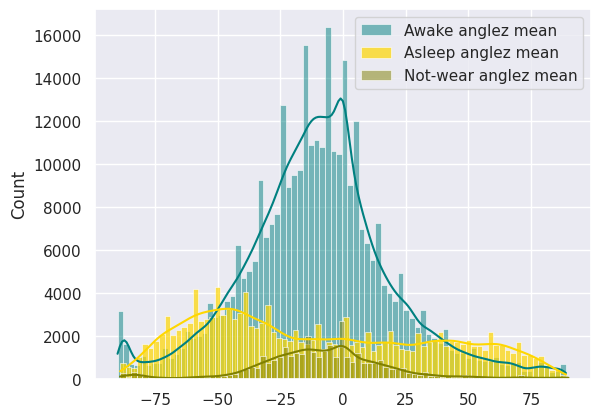

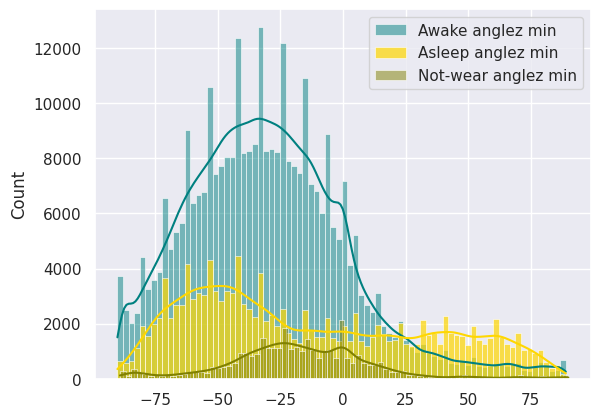

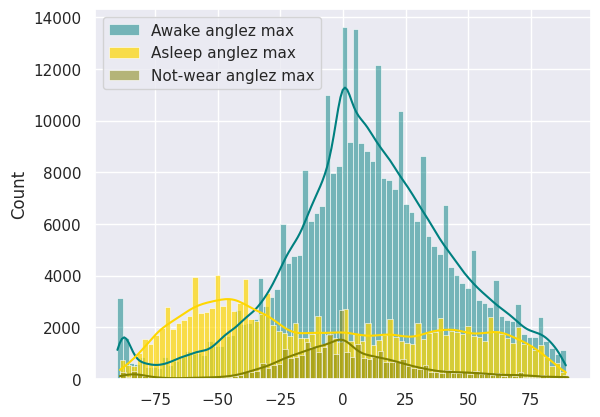

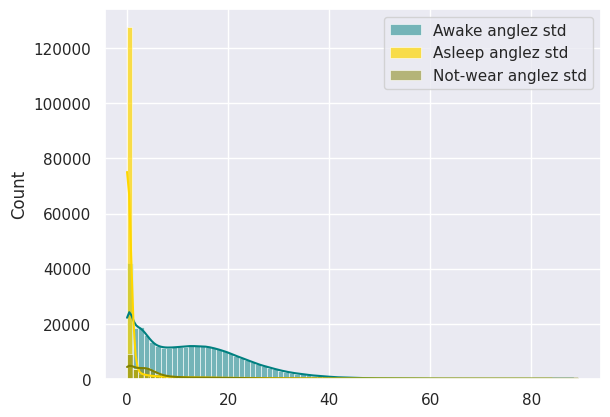

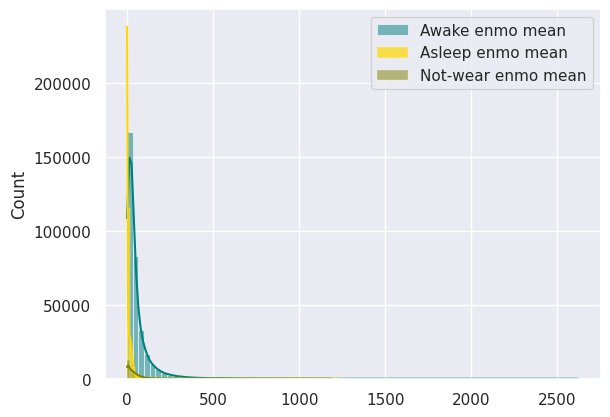

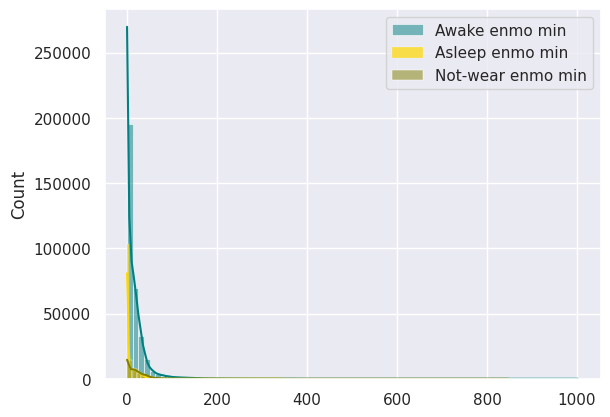

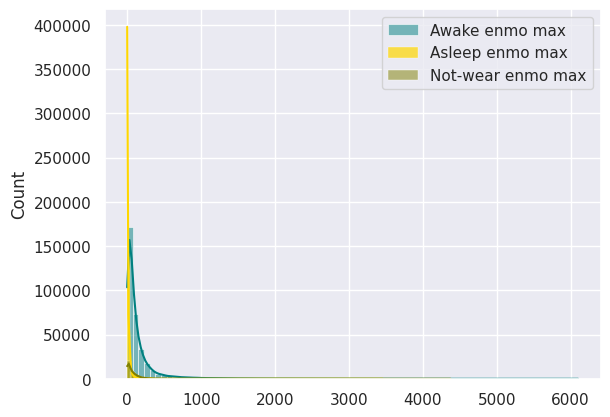

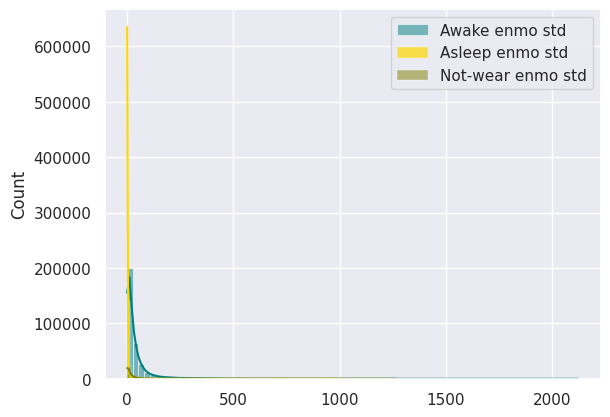

In [64]:
vars = ["anglez", "enmo"]
stats = ["mean", "min", "max", "std"]
for var in vars:
    for stat in stats:
        plot_histogram(var, stat)

In [97]:
def plot_data(df, idx):
    df=df.to_pandas()
    df = df.loc[df['series_id']==idx].sort_values(by='dt_minute')

    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    # Plotting time series data
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['anglez_mean'], mode='lines', name='anglez_mean'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['enmo_mean'], mode='lines', name='enmo_mean'), secondary_y=True)
    
    # Plotting sleeping periods
    onsets = df.loc[(df[labels].diff()!=0)&(df[labels]==1)]['dt_minute'].to_list()
    wakeups = df.loc[(df[labels].diff()==-1)&(df[labels]==0)|(df[labels].diff()==1)&(df[labels]==2)]['dt_minute'].to_list()
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='gray', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='gray', width=0),
        fill='tozeroy',
        fillcolor='gray',
        opacity=0.2,
        name="Sleeping periods"
        ))
    
    # Plotting notwear periods
    onsets = df.loc[(df[labels].diff()>0)&(df[labels]==2)]['dt_minute'].to_list()
    wakeups = df.loc[(df[labels].diff()<0)&(df[labels]!=2)]['dt_minute'].to_list()
    if len(wakeups) < len(onsets):
        wakeups = wakeups + [df["dt_minute"].max()]
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='violet', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='violet', width=0),
        fill='tozeroy',
        fillcolor='violet',
        opacity=0.7,
        name="Not-wear periods"
        ))

    fig.update_layout(
        title_text=f"Accelerometer Data - Full Minutes Averages<br><sub>series_id: {idx}</sub>", 
        #template = 'ggplot2',
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), yaxis2=dict(showgrid=False)
        )
    
    fig.show()

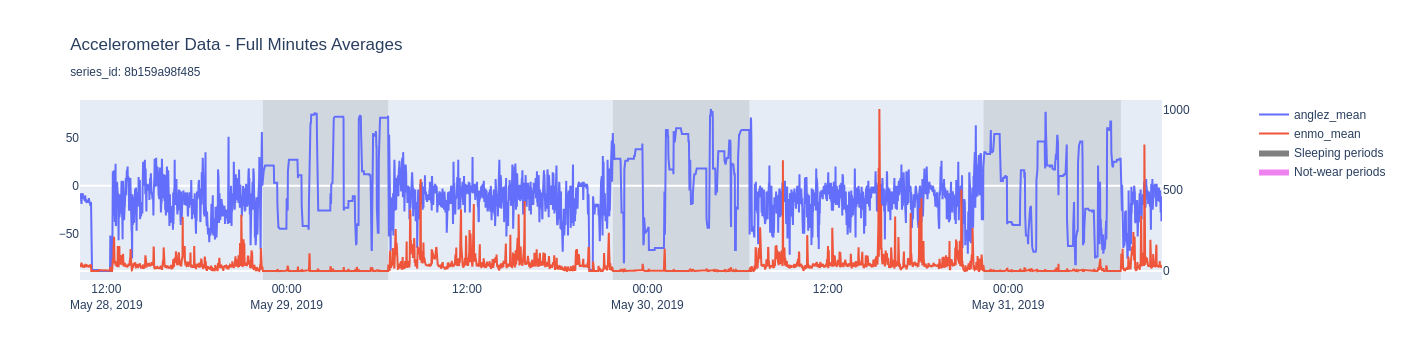

In [98]:
%timeit
plot_data(df, idx=df["series_id"].unique().to_numpy()[0])

In [101]:
def plot_data_polars(df, idx):
    
    df = df.filter(pl.col('series_id')==idx).sort(by='dt_minute')

    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    # Plotting time series data
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['anglez_mean'], mode='lines', name='anglez'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df['dt_minute'], y=df['enmo_mean'], mode='lines', name='enmo'), secondary_y=True)

    
    # Plotting sleeping periods
    onsets = df.filter((df[labels].diff() == 1)&(df[labels]==1))['dt_minute'].to_list()
    wakeups = df.filter((df[labels].diff() == -1)&(df[labels]==0))['dt_minute'].to_list()
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='gray', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='gray', width=0),
        fill='tozeroy',
        fillcolor='gray',
        opacity=0.2,
        name="Asleep"
    ))
    
    
     # Plotting notwear periods
    onsets = df.filter((df[labels].diff() == 2)&(df[labels]==2))['dt_minute'].to_list()
    wakeups = df.filter((df[labels].diff() == -2)&(df[labels]==0))['dt_minute'].to_list()
    if len(wakeups) < len(onsets):
        wakeups = wakeups + [df["dt_minute"].max()]
    for onset, wakeup in zip(onsets, wakeups) :
        fig.add_vrect(
            x0=onset, x1=wakeup,
            fillcolor='violet', opacity=0.2,
            layer='below', line_width=0
        )
        
    # Add dummy trace for the legend
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(color='violet', width=0),
        fill='tozeroy',
        fillcolor='violet',
        opacity=0.7,
        name="Not-wear"
    ))

    fig.update_layout(
        title_text=f"Accelerometer Data<br><sub>ID: {idx}</sub>", 
        # template = 'ggplot2',
        # template = 'seaborn', 
        # template = 'simple_white', 
        template = 'presentation',
        # 'plotly',
         # 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         # 'ygridoff', 'gridon', 'none'
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), yaxis2=dict(showgrid=False),
        # template='plotly_dark',
        # plot_bgcolor='rgba(0, 0, 0, 0)',
        # paper_bgcolor='rgba(0, 0, 0, 0)',
    )
    fig.show()

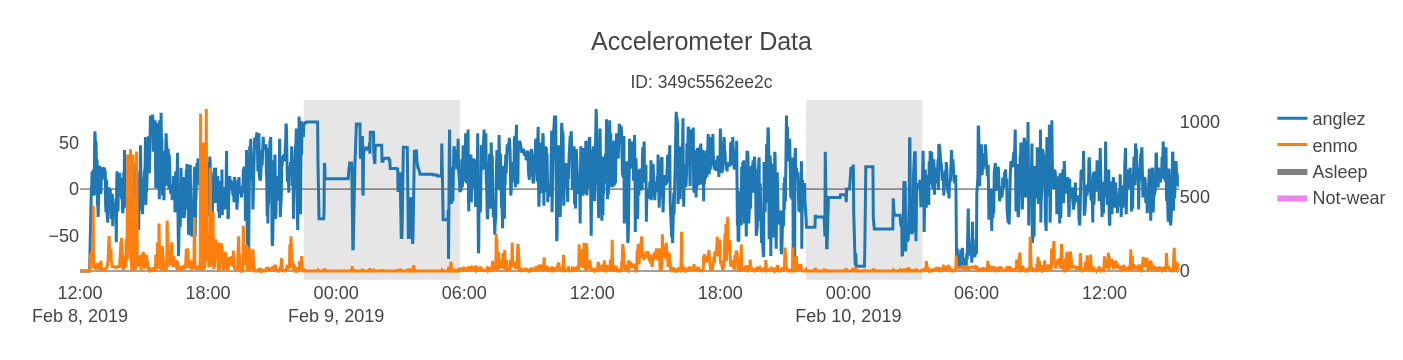

In [102]:
%timeit
plot_data_polars(df, idx=df["series_id"].unique().to_numpy()[0])